In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from tqdm import tqdm
from IPython.display import clear_output

%matplotlib inline

In [2]:
class ES:
    '''
    :param int mode: mode=1 for ES(µ + λ), mode=2 for ES(µ, λ)
    :param int iters: number of iterations
    :param int mu: number of individuals in population
    :param int lambda_: number of children
    :param int K: kind of learning rate
    '''
    
    def __init__(
        self, 
        mode, 
        iters,
        mu, lambda_,
        chromosome_len, 
        eval_f, 
        domain_l=[1], domain_r=[1],
        K=0.6, tau0=None, tau1=None, 
        visualize=None, visualize_every=None,
        arms=[], goal=None, arms_ranges=[],
        polygons=[],
        show_all=False
    ):
        
        self.mode = mode
        self.iters = iters
        self.mu = mu
        self.lambda_ = lambda_
        self.d = chromosome_len
        self.eval_f = eval_f
        self.domain_l = domain_l
        self.domain_r = domain_r
        self.K = K
        self.tau0 = tau0
        self.tau1 = tau1
        
        self.visualize = visualize
        self.visualize_every = visualize_every
        self.arms = arms
        self.arms_ranges = arms_ranges
        self.polygons = polygons
        self.goal = goal
        self.show_all = show_all
        
        if self.tau0 is None:
            self.tau0 = K / np.sqrt(2 * np.sqrt(self.d))
            
        if self.tau1 is None:
            self.tau1 =  K / np.sqrt(2 * self.d)
        
        
        chromosomes = np.random.uniform(
            low=np.array(domain_l),
            high=np.array(domain_r),
            size=(self.mu, self.d)
        )
        
        _, chromosomes = self.constrained_X(chromosomes)
        
        sigmas = np.random.uniform(
            low=np.zeros(len(domain_r)), # 0
            high=np.array(domain_r) / np.array(domain_r).max(), # ?
            size=(self.mu, self.d)
        )
        
        self.P = np.hstack((
            chromosomes,
            sigmas
        ))
        
        self.cost = eval_f(self.P[:, :self.d])
        self.cost_history = []
        self.population_history = []
        self.sigmas_history = []
        self.best_sigmas_history = []
        
    def parents_selection(self):
        # Softmax
#         fitness_values = np.exp(self.cost) / np.sum(np.exp(self.cost))
        
#        Normalize
#         if abs(self.cost.max() - self.cost.min()) > 1e-3:
#             fitness_values = (self.cost - self.cost.min()) / (self.cost.max() - self.cost.min())
#         fitness_values /= fitness_values.sum()

        fitness_values = self.cost
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / len(fitness_values) * np.ones(len(fitness_values)) 
            
        ids = np.random.choice(
            np.arange(self.cost.size),
            size=self.lambda_,
            replace=True,
            p=fitness_values
        )
        return self.P[ids]
    
    
    def constrained_X(self, X, old_X=None):
        X = np.array(
            [
                [
    #                         max(min(x, self.arms_ranges[i][1]), self.arms_ranges[i][0]) for i, x in enumerate(row)
                    np.random.uniform(self.arms_ranges[i][0], self.arms_ranges[i][1])
                        if x < self.arms_ranges[i][0] or x > self.arms_ranges[i][1] 
                        else x 
                    for i, x in enumerate(row)
                ]
                for row in X
            ]
        )
        
        if len(self.polygons) == 0:     
            return [], X
        else:
            def intersect_with_polygons(p):
                angle = 0
                x, y = 0, 0
                for i, a in enumerate(p):
                    arm = arms[i]
                    angle += a
                    new_x = x + arm * np.sin(angle * np.pi / 180)
                    new_y = y + arm * np.cos(angle * np.pi / 180)
                    if polyLine(self.polygons, x, y, new_x, new_y):
                        return True
                    x, y = new_x, new_y
                return False
            
            def get_random_indi(p):
                chromosome = np.random.uniform(
                    low=np.array(self.domain_l),
                    high=np.array(self.domain_r),
                    size=self.d
                )
                return chromosome
            
            bad_indi, ans_X = [], []
            for i, p in enumerate(X):
                no = 0
                first = True
                while(intersect_with_polygons(p)):
                    no += 1
                    if first and old_X is not None:
                        p = old_X[i]
                        first = False
                        bad_indi.append(i)
                    else:
                        p = get_random_indi(p)
                    if no > 1000:
                        raise ValueError("Polygons always intersect!")
                ans_X.append(p)
            
            return np.array(bad_indi), np.array(ans_X)
                
        
    
    
    def mutation(self, parents):
        X = parents[:, :self.d]
        Sigmas = parents[:, self.d:]
    
        E = np.random.normal(0, self.tau1, size=Sigmas.shape)
        eps_o = np.random.normal(0, self.tau0)
        Sigmas *= np.exp(E + eps_o)
        
        new_X = X + np.random.normal(0, 1, size=Sigmas.shape) * Sigmas
        
        # in case some of the values are violating the constrains 
        indi, new_X = self.constrained_X(new_X, X)
        if len(indi) > 0:
            Sigmas[indi] = np.random.uniform(
                low=np.zeros(len(self.domain_r)),
                high=np.array(self.domain_r) / np.array(self.domain_r).max(),
                size=(len(indi), self.d)
            )
       
        return np.hstack((
            new_X,
            Sigmas
        ))
    
    
    def replacement(self, children, children_cost):
        P, costs = None, None
        if self.mode == 1: # ES(µ + λ)
            P = np.vstack((self.P, children))
            costs = np.hstack((self.cost, children_cost))
        
        elif self.mode == 2: # ES(µ, λ)
            P = children
            costs = children_cost
        
        else:
            raise ValueError(f'Wrong mode! {self.mode}')
            
        best = np.argsort(costs)[:self.mu]
        return P[best], costs[best]
            
        
        
    def run(self):
        desc = ['ES(µ + λ)', 'ES(µ, λ)'][self.mode - 1]
        for i in tqdm(range(self.iters), desc=f'{desc}', position=0):
#         for i in range(self.iters):
            children = self.parents_selection()
            children = self.mutation(children)
            children_cost = self.eval_f(children[:, :self.d])
            
            self.P, self.cost = self.replacement(children, children_cost)
            self.cost_history.append((self.cost.min(), self.cost.mean(), self.cost.max()))
            self.population_history.append(self.P[:, :self.d])
            self.sigmas_history.append(self.P[:, self.d:].mean(axis=0)) # mean of sigmas in population
            
            best_indi = self.cost.argmin()
            self.best_sigmas_history.append(self.P[:, self.d:][best_indi]) # sigmas of best indi
            
            
            if np.abs(self.P[:, self.d].mean()) < 1e-4:
                print('Early stopping')
                clear_output(wait=True)
                fig, ax = plt.subplots(figsize=(9, 9))
                ax.set_aspect('equal')
                self.visualize(
                    n = self.d,
                    L = self.arms,
                    A = self.P[:, :self.d][best_indi],
                    polygons=self.polygons,
                    goal = self.goal
                )
                break
            
            if self.visualize_every is not None and self.visualize is not None:
                if i % self.visualize_every == 0:
                    clear_output(wait=True)
                    fig, ax = plt.subplots(figsize=(9, 9))
                    ax.set_aspect('equal')
                    self.visualize(
                        n = self.d,
                        L = self.arms,
                        A = self.P[:, :self.d][best_indi],
                        polygons=self.polygons,
                        goal = self.goal,
                        alpha = 1,
                        show = False
                    )
                    if self.show_all:
                        for p in self.P[:, :self.d]:
                            self.visualize(
                                n = self.d,
                                L = self.arms,
                                A = p,
                                goal = self.goal,
                                alpha = 0.1,
                                show = False
                            )
            
                    plt.title(f'Best cost: {self.cost[best_indi]}')
                    plt.show()
            
        self.cost_history = np.array(self.cost_history)
        self.mini_id = self.cost_history[:, 0].argmin()
        self.mini_val = self.cost_history[:, 0][self.mini_id]
        population_batch = self.population_history[self.mini_id]
        population_mini_id = self.eval_f(population_batch[:, :self.d]).argmin()
        self.best_individual = population_batch[population_mini_id]
            
    def plot_cost(self):
        plt.figure(figsize=(15, 5))
        plt.plot(self.cost_history)
        desc = ['ES(µ + λ)', 'ES(µ, λ)'][self.mode - 1]
        plt.title(f'{desc} --> POPULATION SIZE: {self.mu}  |  CHROMOSOME LEN: {self.d}  |  ITERS: {self.iters}  |  BEST_ITER: {self.mini_id}  |  MIN: {self.mini_val :.3f}')
        plt.legend(['Min','Mean', 'Max'], loc='upper right')
#         print(f'Best individual: {best_individual[:self.d]}')
#         print(f'Func val: {self.eval_f(np.array(best_individual[:self.d])[np.newaxis])}')
        plt.show()
        
    def plot_sigmas(self, sigmas, title):
        plt.figure(figsize=(15, 5))
        plt.title(title)
        plt.plot(sigmas)
        plt.show()

![](inverse_kinematics.png)

### Problem visualization

In [3]:
def visualize_arms(
    n, # number of arms
    L, # list of arms lengths
    A, # list of angles
    goal, # goal point
    polygons = [],
    alpha = 1, # transparency
    show = True
):
    
    angle = 0
    x, y = 0, 0
    if alpha == 1:
#         plt.figure(figsize=(9, 9))
        plt.scatter(goal[0], goal[1], s=250, c='yellow', edgecolors='black', marker='X')
        plt.scatter(x, y, s=150, c='black')
        plt.plot((-2, 2), (0, 0), c='black', linewidth=7)
        
        for P in polygons:
            next_ = 0
            for i in range(len(P)):
                next_ = i + 1
                if next_ == len(P):
                    next_ = 0
                plt.plot((P[i][0], P[next_][0]), (P[i][1], P[next_][1]), color='black', linewidth=4)
             
        
    for i in range(n):
        arm = L[i]
        angle += A[i]
        new_x = x + arm * np.sin(angle * np.pi / 180)
        new_y = y + arm * np.cos(angle * np.pi / 180)
        if alpha == 1:
            plt.scatter(new_x, new_y, edgecolor='black', s=150)
            plt.plot((x, new_x), (y, new_y), alpha=alpha)
        else:
             plt.plot((x, new_x), (y, new_y), alpha=alpha, c='black')
        x, y = new_x, new_y
    
    if show:
        plt.show()

## Line - Polygon interception

In [4]:
def lineLine(
    x1, y1, 
    x2, y2, 
    x3, y3, 
    x4, y4
):
    '''
    Intersection between two lines
    '''
    uA = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))
    uB = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / ((y4-y3)*(x2-x1) - (x4-x3)*(y2-y1))

   
    if uA >= 0 and uA <= 1 and uB >= 0 and uB <= 1:
        return True;

    return False;



def polyLine(
    vertices, # list of vertices of polygons
    x1, y1,   # one point of the line
    x2, y2    # second point of the line
): 
    '''
    Intersection between a polygon and a line
    
    :param list vertices: list of polygon's vertices 
    '''
    for v in vertices:
        next_ = 0;
        for current in range(len(v)):

            next_ = current+1
            if next_ == len(v):
                next_ = 0

            x3 = v[current][0];
            y3 = v[current][1];
            x4 = v[next_][0];
            y4 = v[next_][1];

            hit = lineLine(x1, y1, x2, y2, x3, y3, x4, y4);
            if hit:
                return True;

    return False

### Define cost function

In [5]:
def cost_function(P, goal, arms):
    assert(P.shape[1] == len(arms))
    
    ans = []
    for p in P:
        angle = 0
        x, y = 0, 0
        for i, a in enumerate(p):
            arm = arms[i]
            angle += a
            x += arm * np.sin(angle * np.pi / 180)
            y += arm * np.cos(angle * np.pi / 180)
        ans.append((x - goal[0]) ** 2 + (y - goal[1]) ** 2)
        
    return np.array(ans)

### Problem engine

In [6]:
def inverse_kinematics(
    n, L, K,
    iters,
    mu, lambda_,
    goal,
    cost_f,
    visualize, visualize_every,
    polygons = [],
    lr = 1,
    show_all = False
):
    '''
    :param int n: number of arms
    :param list L: lengths of arms
    :param list of pairs K: range of angles for each arm, 
        K[i] = (a, b), so a <= α[i] <= b
        
    '''
    assert(len(L) == n and len(K) == n)
    model = ES(
        mode = 1,
        iters = iters,
        mu = mu, lambda_ = lambda_, 
        chromosome_len = n, 
        eval_f = cost_f, 
        domain_l = np.array(K)[:, 0], domain_r = np.array(K)[:, 1], 
        K=lr, tau0=None, tau1=None,
        visualize = visualize,
        visualize_every = visualize_every,
        arms = L,
        arms_ranges = K,
        polygons = polygons,
        goal = goal,
        show_all = show_all
    )
    
    model.run()
    model.plot_cost()
    model.plot_sigmas(model.best_sigmas_history,title='Mean sigmas of best individuals')
    model.plot_sigmas(model.sigmas_history, title='Mean sigmas of the whole population')

## Playground 1

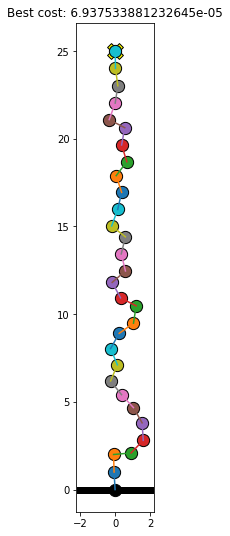

ES(µ + λ): 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.40it/s]


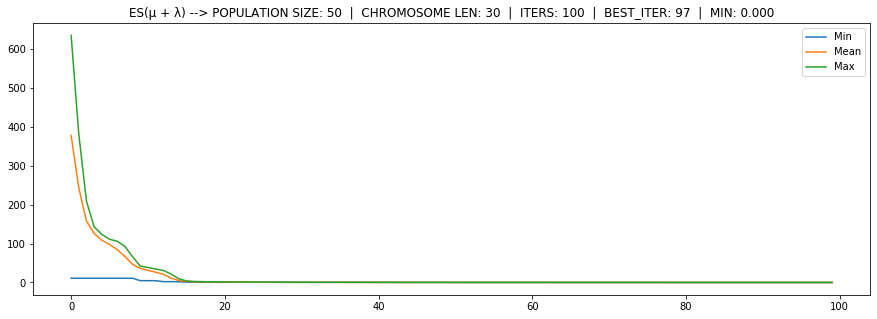

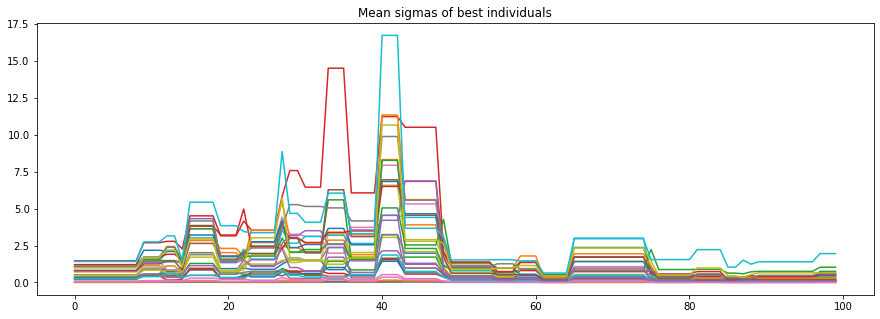

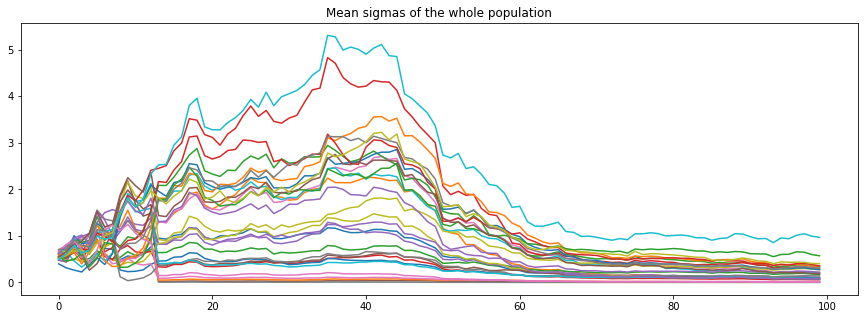

In [11]:
arms = [1] * 30 
goal = (0, 25)
arms_ranges = [(-90, 90)] * len(arms)


inverse_kinematics(
    n = len(arms),
    L = arms,
    K = arms_ranges,
    polygons = [],
    iters = 100,
    mu=50, lambda_=100,
    goal = goal,
    cost_f = lambda x: cost_function(x, goal, arms),
    lr = 1,
    visualize = visualize_arms, 
    visualize_every = 1,
    show_all = False
)

## Playground 2


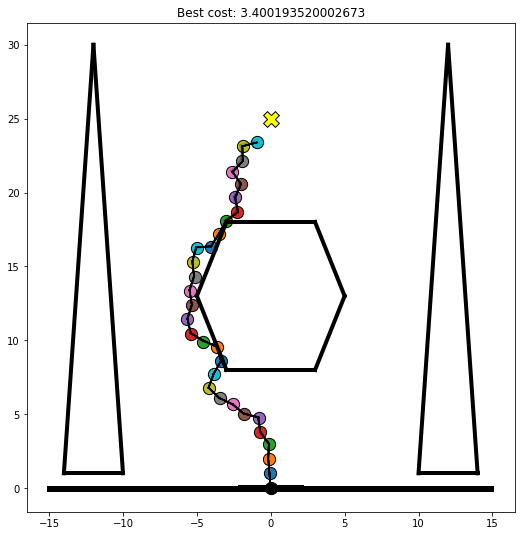

ES(µ + λ): 100%|█████████████████████████████████████████████████████████████████████| 100/100 [02:30<00:00,  1.51s/it]


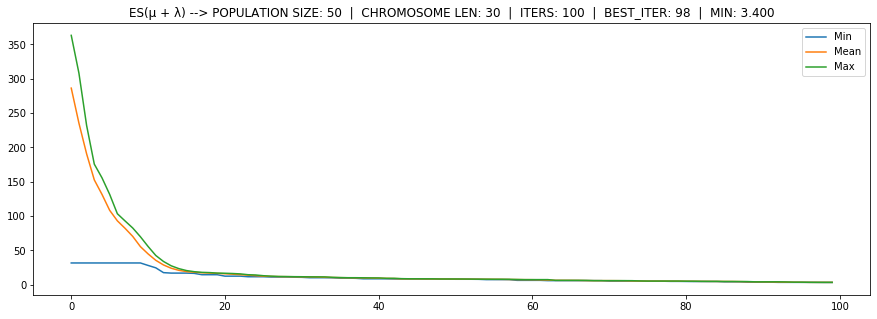

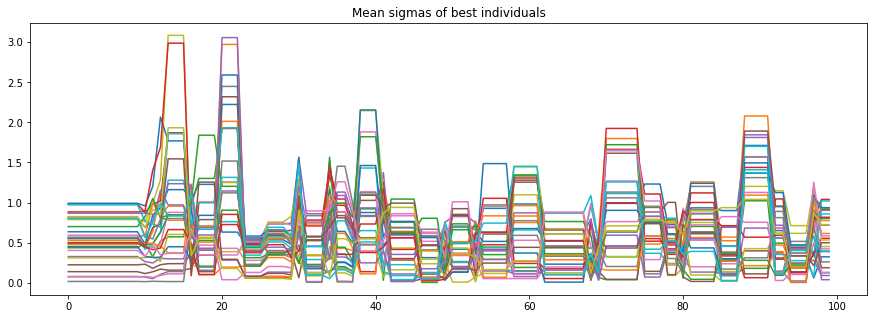

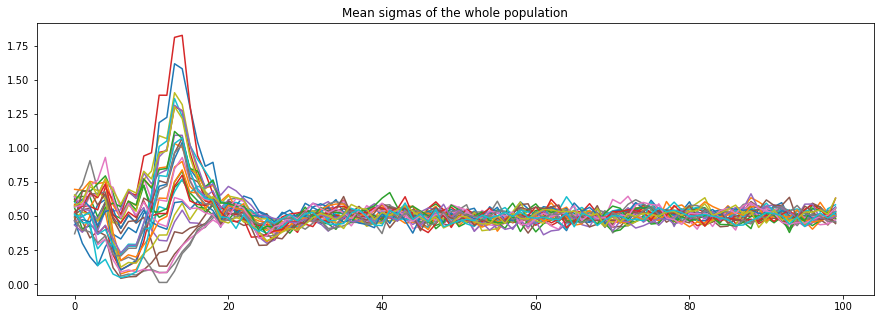

In [13]:
arms = [1] * 30 
goal = (0, 25)
arms_ranges = [(-90, 90)] * len(arms)
polygons = [
    [(-15, -0.01), (15, -0.01), (15, -0.1), (-15, -0.1)], 
    [(-3, 8), (-5, 13), (-3, 18), (3, 18), (5, 13), (3, 8)], 
    [(10, 1), (12, 30), (14, 1)],
    [(-10, 1), (-12, 30), (-14, 1)],
]


inverse_kinematics(
    n = len(arms),
    L = arms,
    K = arms_ranges,
    polygons = polygons,
    iters = 100,
    mu=50, lambda_=100,
    goal = goal,
    cost_f = lambda x: cost_function(x, goal, arms),
    lr = 1,
    visualize = visualize_arms, 
    visualize_every = 2,
    show_all = True
)

## Dataset 1

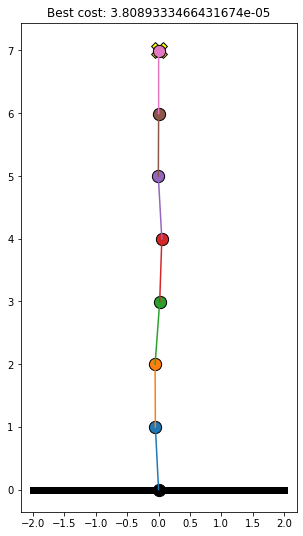

ES(µ + λ): 100%|█████████████████████████████████████████████████████████████████████| 300/300 [00:09<00:00, 31.64it/s]


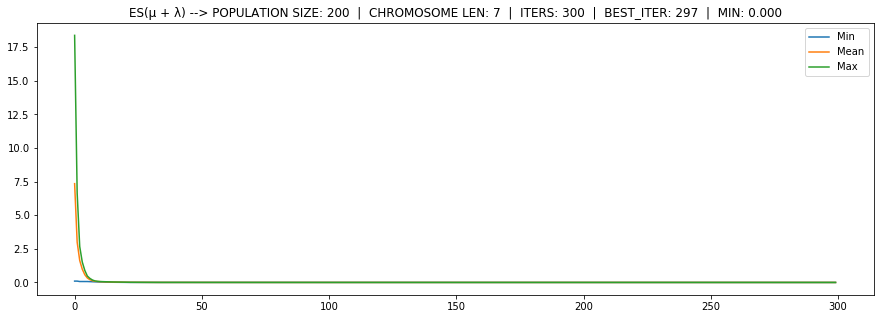

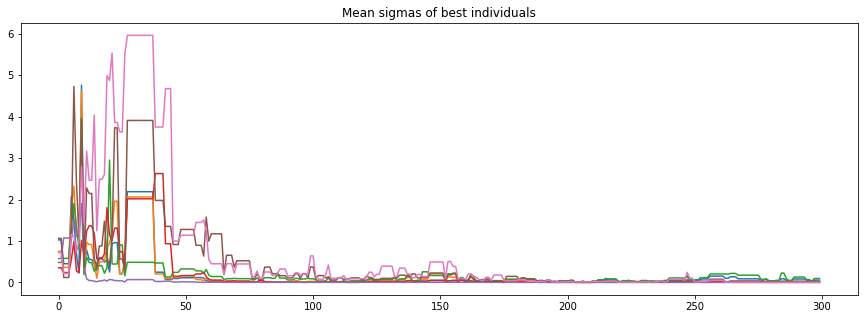

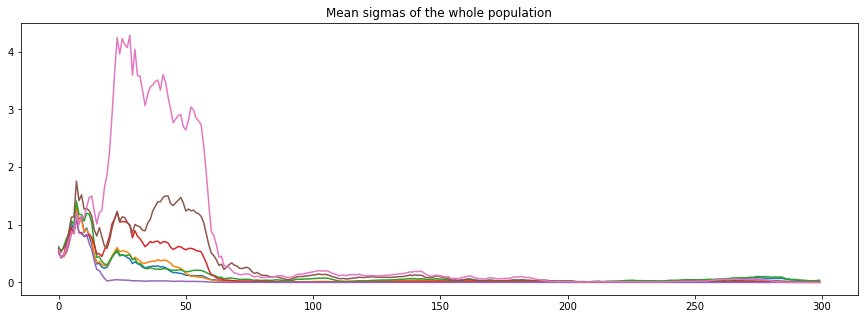

In [286]:
arms = [1, 1, 1, 1, 1, 1, 1]
goal = (0, 7)
arm_ranges = [(-45, 45)] * len(arms)

inverse_kinematics(
    n = len(arms),
    L = arms,
    K = arm_ranges,
    iters = 300,
    mu=200, lambda_=500,
    goal = goal,
    cost_f = lambda x: cost_function(x, goal, arms),
    lr = 0.7,
    visualize = visualize_arms, 
    visualize_every = 10,
    show_all = False
)

## Dataset 2

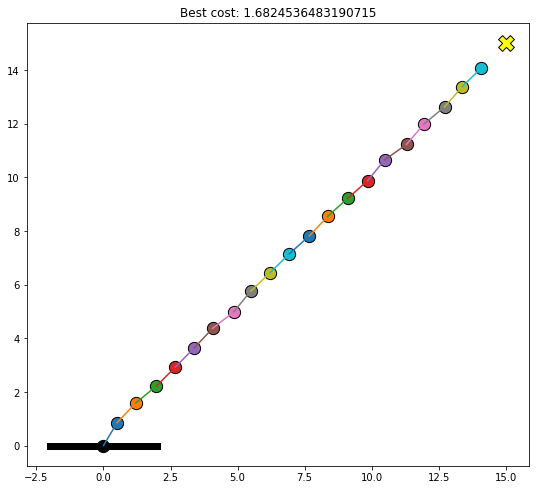

ES(µ + λ): 100%|█████████████████████████████████████████████████████████████████████| 200/200 [01:20<00:00,  2.49it/s]


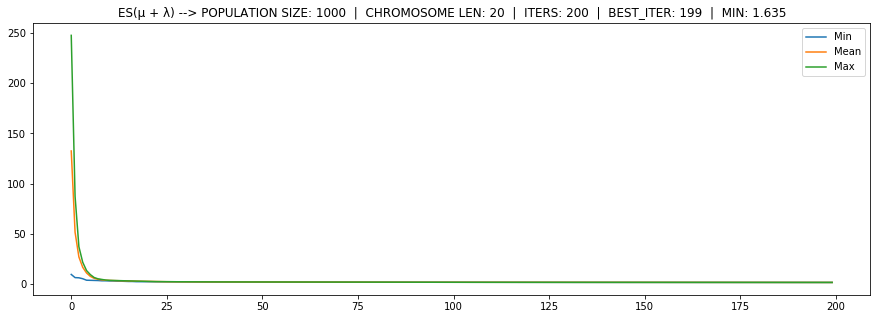

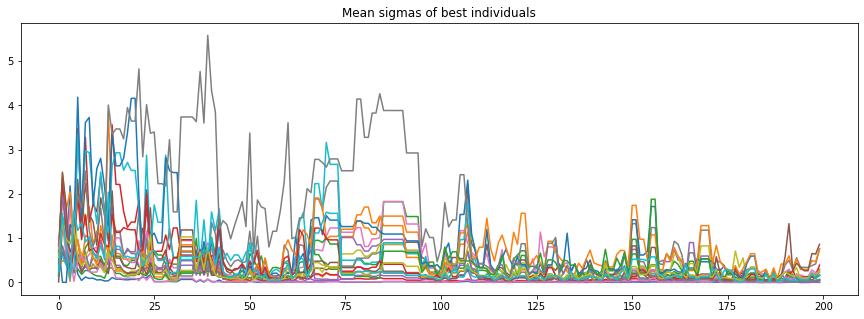

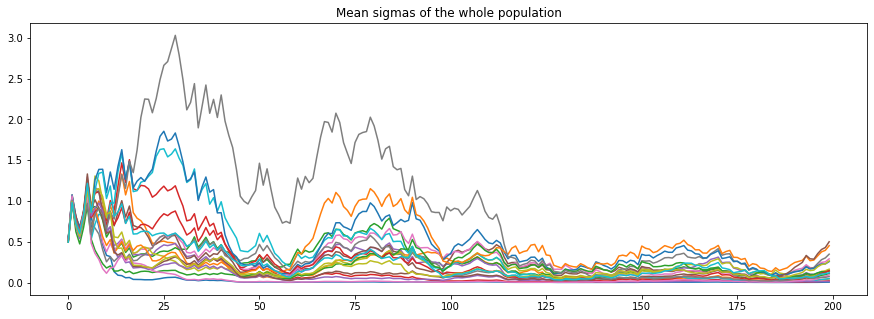

In [292]:
arms = [1] * 20
goal = (15, 15)
arm_ranges = [(-45, 45)] * len(arms)

inverse_kinematics(
    n = len(arms),
    L = arms,
    K = arm_ranges,
    iters = 200,
    mu=1000, lambda_=5000,
    goal = goal,
    cost_f = lambda x: cost_function(x, goal, arms),
    lr = 1,
    visualize = visualize_arms, 
    visualize_every = 50,
    show_all = False
)

## Dataset 3

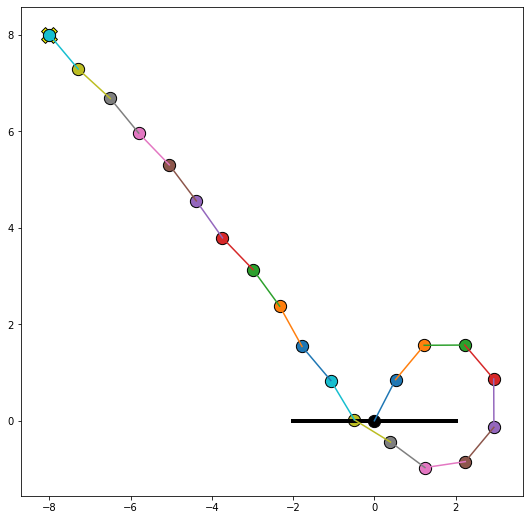

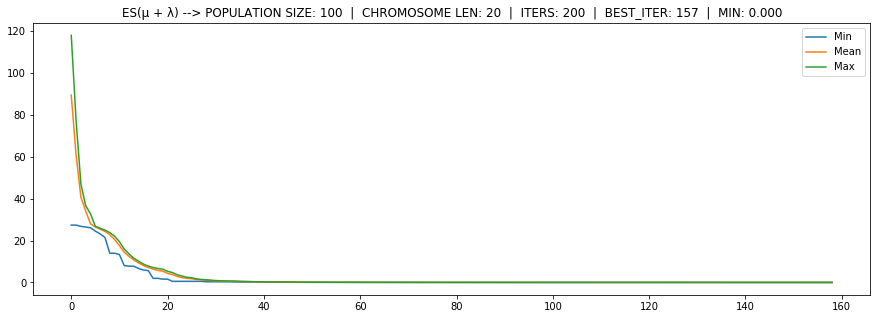

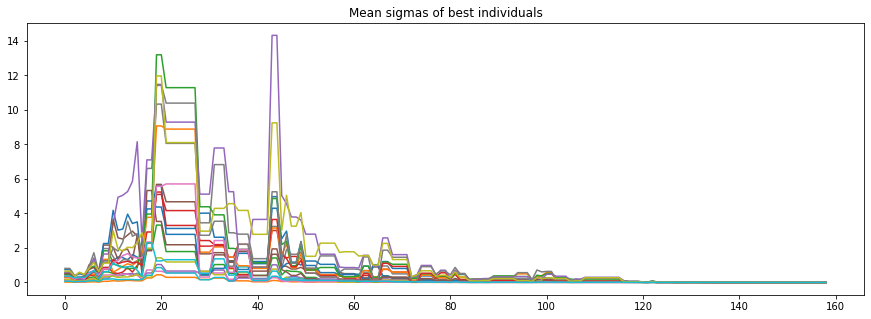

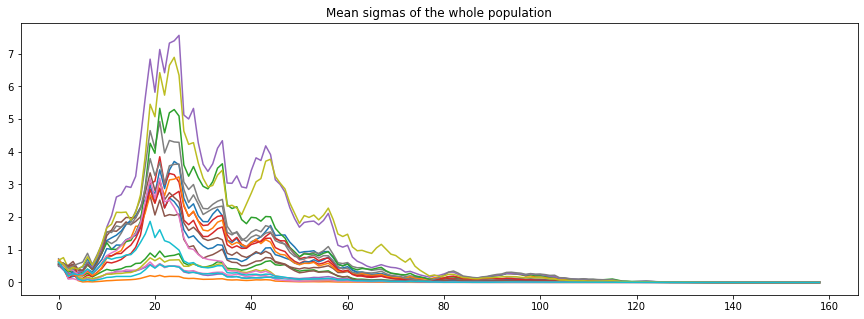

ES(µ + λ):  78%|█████████████████████████████████████████████████████▊               | 156/200 [00:28<00:04, 10.91it/s]

In [10]:
arms = [1] * 20
goal = (-8, 8)
arms_ranges = [(-10, 45)] * len(arms)

inverse_kinematics(
    n = len(arms),
    L = arms,
    K = arms_ranges,
    iters = 200,
    mu=100, lambda_=500,
    goal = goal,
    cost_f = lambda x: cost_function(x, goal, arms),
    lr = 1,
    visualize = visualize_arms, 
    visualize_every = 5,
    show_all = False
)

## Dataset 4

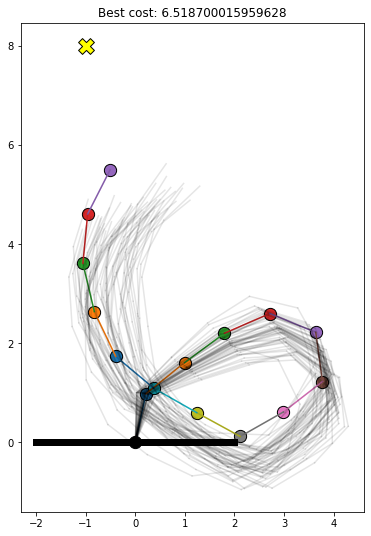

ES(µ + λ): 100%|███████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.78it/s]


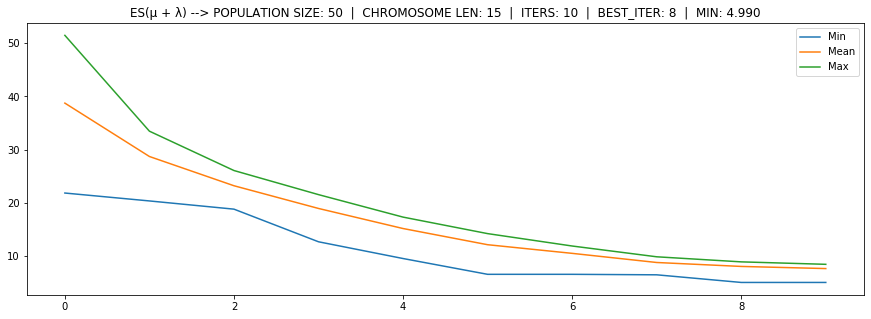

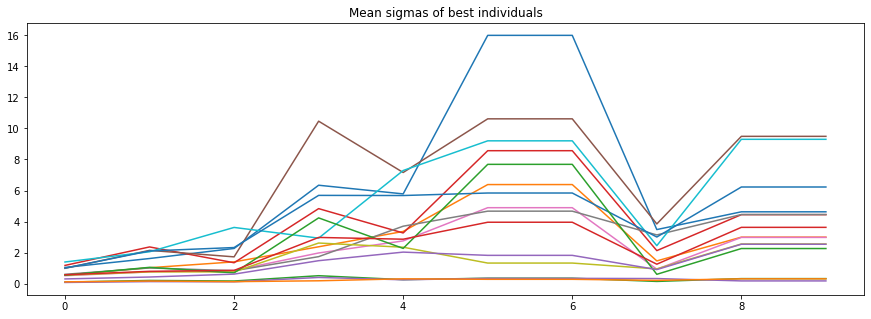

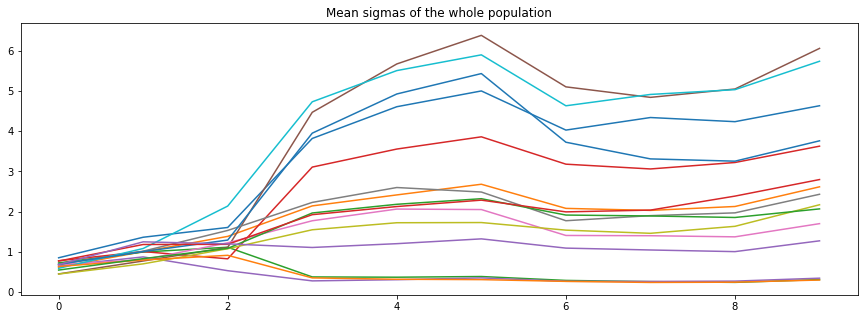

In [294]:
arms = [1] * 15
goal = (-1, 8)
arms_ranges = [(0, 60)] * len(arms)


inverse_kinematics(
    n = len(arms),
    L = arms,
    K = arms_ranges,
    iters = 10,
    mu=50, lambda_=200,
    goal = goal,
    cost_f = lambda x: cost_function(x, goal, arms),
    lr = 1,
    visualize = visualize_arms, 
    visualize_every = 5,
    show_all = True
)

## Dataset 5

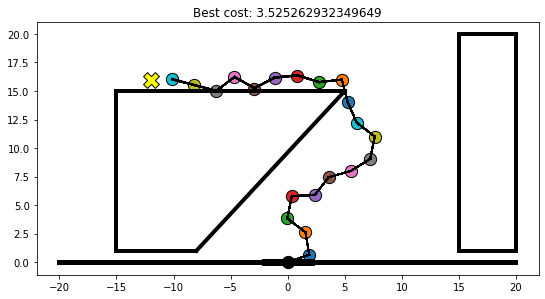

ES(µ + λ): 100%|█████████████████████████████████████████████████████████████████████| 100/100 [05:45<00:00,  3.46s/it]


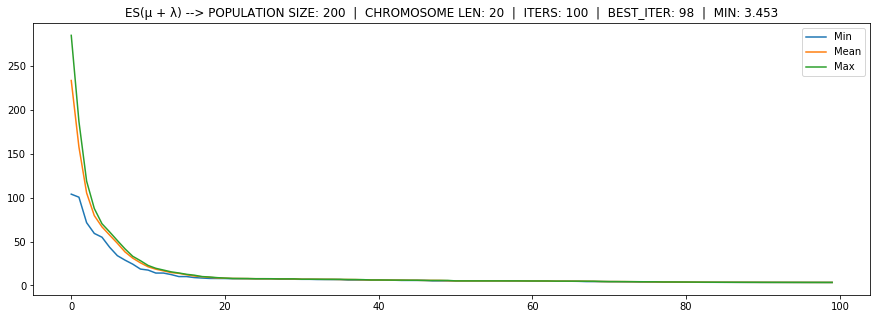

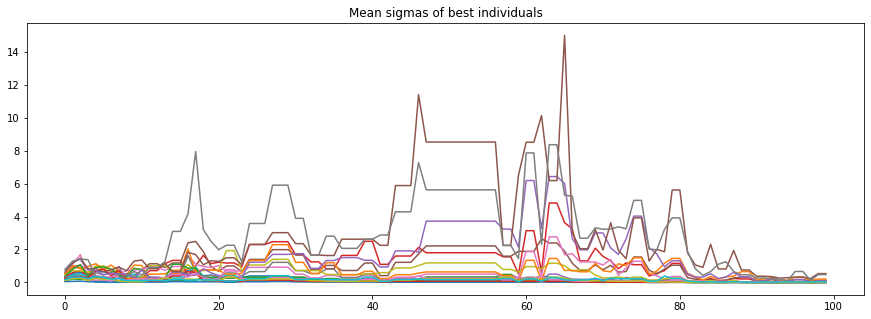

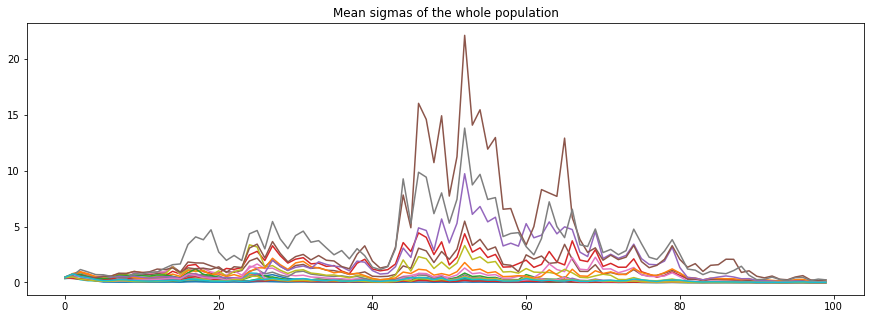

In [252]:
arms = [2] * 20
goal = (-12, 16)
arms_ranges = [(-90, 90)] * len(arms)
polygons = [
    [(-20, -0.01), (20, -0.01), (20, -0.1), (-20, -0.1)], 
    [(-15, 1), (-15, 15), (5, 15), (-8, 1)], 
    [(15, 1), (15, 20), (20, 20), (20, 1)]
]


inverse_kinematics(
    n = len(arms),
    L = arms,
    K = arms_ranges,
    polygons = polygons,
    iters = 100,
    mu=200, lambda_=2000,
    goal = goal,
    cost_f = lambda x: cost_function(x, goal, arms),
    lr = 1,
    visualize = visualize_arms, 
    visualize_every = 10,
    show_all = True
)

## Dataset 6

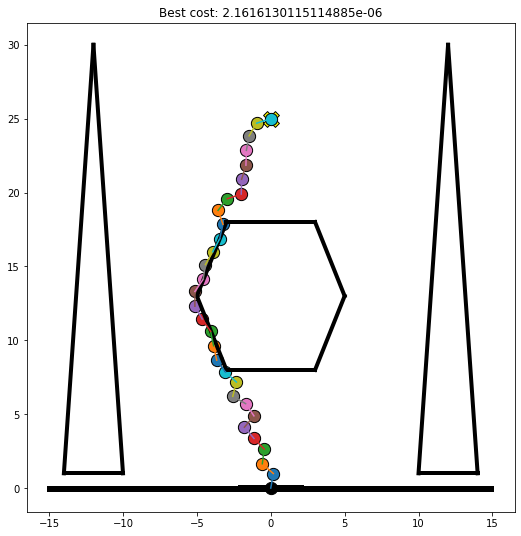

ES(µ + λ): 100%|█████████████████████████████████████████████████████████████████████| 300/300 [12:10<00:00,  2.43s/it]


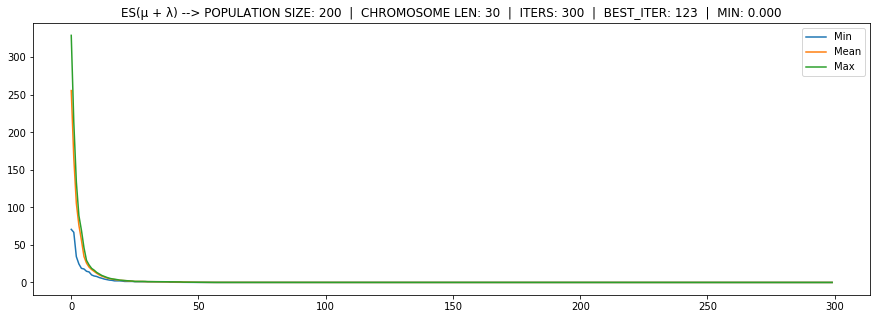

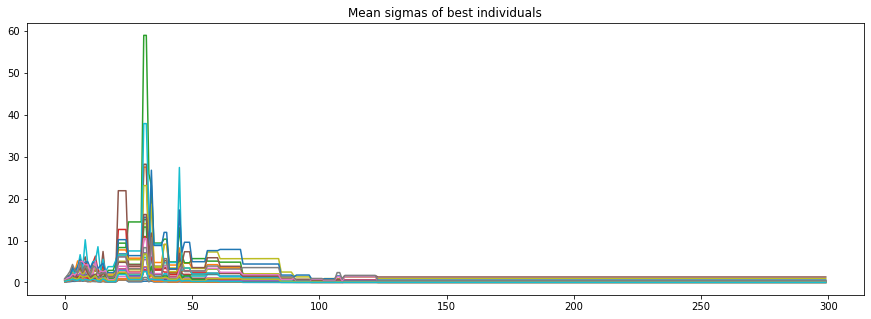

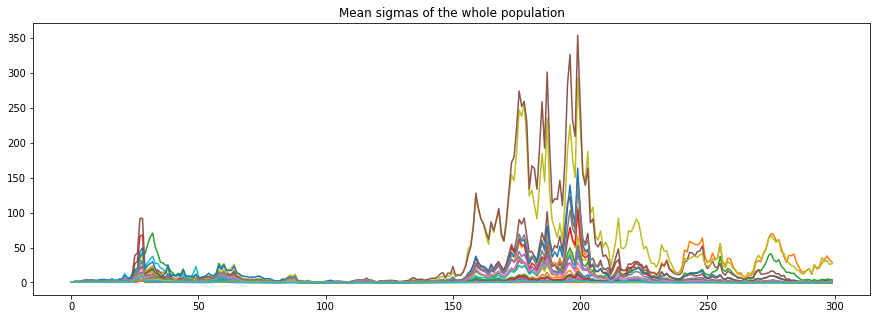

In [274]:
arms = [1] * 30 
goal = (0, 25)
arms_ranges = [(-90, 90)] * len(arms)
polygons = [
    [(-15, -0.01), (15, -0.01), (15, -0.1), (-15, -0.1)], 
    [(-3, 8), (-5, 13), (-3, 18), (3, 18), (5, 13), (3, 8)], 
    [(10, 1), (12, 30), (14, 1)],
    [(-10, 1), (-12, 30), (-14, 1)],
]


inverse_kinematics(
    n = len(arms),
    L = arms,
    K = arms_ranges,
    polygons = polygons,
    iters = 300,
    mu=200, lambda_=1000,
    goal = goal,
    cost_f = lambda x: cost_function(x, goal, arms),
    lr = 1,
    visualize = visualize_arms, 
    visualize_every = 50,
    show_all = False
)

## Dataset 7

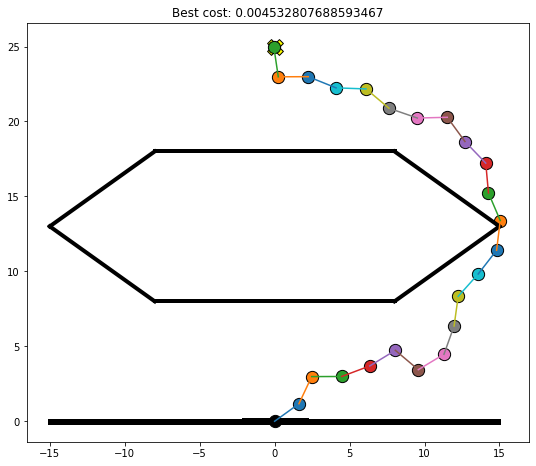

ES(µ + λ): 100%|█████████████████████████████████████████████████████████████████████| 100/100 [00:49<00:00,  2.01it/s]


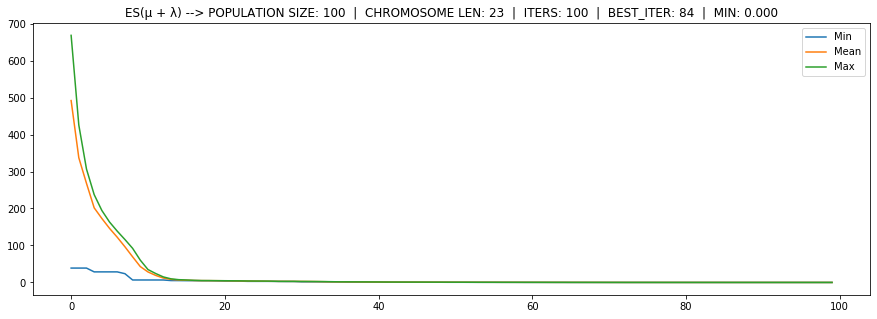

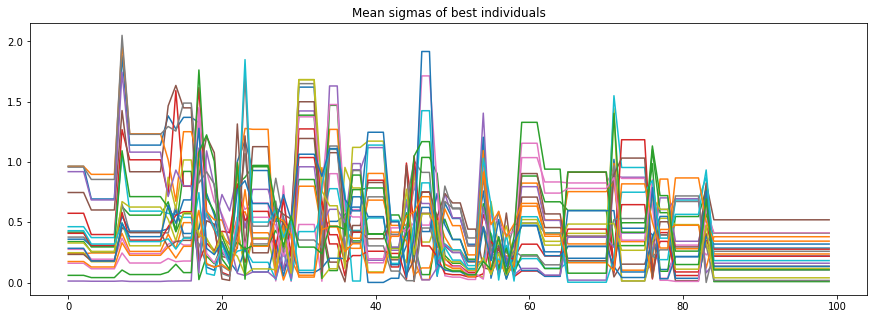

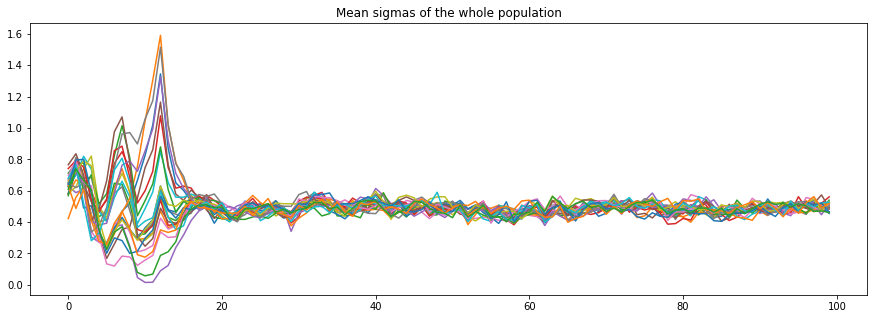

In [10]:
arms = [2] * 23
goal = (0, 25)
arms_ranges = [(-90, 90)] * len(arms)
polygons = [
    [(-15, -0.01), (15, -0.01), (15, -0.1), (-15, -0.1)], 
    [(-8, 8), (-15, 13), (-8, 18), (8, 18), (15, 13), (8, 8)], 
]


inverse_kinematics(
    n = len(arms),
    L = arms,
    K = arms_ranges,
    polygons = polygons,
    iters = 100,
    mu=100, lambda_=400,
    goal = goal,
    cost_f = lambda x: cost_function(x, goal, arms),
    lr = 1,
    visualize = visualize_arms, 
    visualize_every = 20,
    show_all = False
)